# Collecting Typical Blobs based on pre-detected cells

To do list - For pair-wise matching perceptron, on single section first, then extent to multiple nearby sections
1. Get the contour for each structure
2. Get the marginal area for each strucutre 
3. Get the blobs in each structure 
4. Get the blobs in the marginal area of a structure
5. Compute pair-wise similarity vector, construct training set
6. Feed training set into the perceptron. Train with positive and negative examples
7. Get the weight for collecting blob
    - Compute confusion matrix
    - Examine the flase-positive and the true-negative result
    - Look at the example
    - Try to eliminate small cells and involve multiple section
    - Ask Yuncong alternative method
    - Consider changing the original code with Lagrangian operators with normalization to get weights

8. repeat the above process for multiple structures and see if the weight vaires a lot for different structure
9. Extend the algorithms to multiple sections
10. ....

### Conclusions:
1. Suppose that all the blobs detected within the annotation structures are typical and those blobs in the margin of the structure are not typical(negative training set). In N7, inituitively I thing the large cells are typical while the small cells are not typical(since they are quite similar with the surrounding cells. As a result, the positive training set is too noisy. 
2. The perceptron gives unnormalized weight. Moreover, some of the weights are negative. How to get a normalized, positve-definite weight? Modify the stochastic gradient descent, use Lagragrian operator and normalized the weight in every single iteration? Not sure if it works. 
3. The result of perceptron is highly unstable. The training accuracy varies a lot between trainings with the same data set. I gauss it depends on the order of the input data. Maybe using some ohter method with global optimization will be better?


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/

In [45]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = max_0+margin
    if max_0 > im0max:
        raise ValueError('Warning: The default limit is used. Please specify the image size')
        max_0 = im0max
    min_1 = max(min_1-margin,0)
    max_1 = max_1+margin
    if max_1 > im1max:
        raise ValueError('Warning: The default limit is used. Please specify the image size')
        max_1 = im1maxV
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc
    
def fun_mxmx2mmxx(min_0,max_0,min_1,max_1):
    return (min_0,min_1,max_0,max_1)

def fun_mmxx2mxmx(min_0,min_1,max_0,max_1):
    return (min_0,max_0,min_1,max_1)

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/abs(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'area':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'eccentricity':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'moments_hu':
            difference = np.abs(np.abs(oriIprops) - np.abs(np.array(nextIprops[i],dtype=np.float)))/np.abs( np.max(np.abs(np.vstack((oriIprops,nextIprops[i]))),axis=0) + 10**(-16)) 
        
        elif distance_type == 'equivalent_diameter':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'orientation':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            similarity.append(np.cos(diff_angle))
            continue
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle) 
        similarity.append( 1 - difference) 
    return similarity

def fun_reconstruct_labeled_image(cell_global_coord,oriImL0, oriImL1, crop_range=None, op_clear_border=True,op_relabel=True):
    """ cell_global_coord = list of coordinate of the global index position of all the pixel in each blob
        oriImL1, oriImL0 = metadata_cache['image_shape][stack]
        crop_range = (min0, max0, min1, max1)
        return: labeled_image, blob_prop_List
    """
    cell_numbers = len(cell_global_coord);
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    
    for tempBlobIndex in range(cell_numbers):
        tempBlobCoor = cell_global_coord[tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if crop_range is not None:
        crop_0_min = crop_range[0]
        crop_0_max = crop_range[1]
        crop_1_min = crop_range[2]
        crop_1_max = crop_range[3]
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if op_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)
        
    if op_relabel:
        im_label_ori = tempLabeledImage
        tempLabeledImage = skimage.measure.label(tempLabeledImage > 0)
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop, im_label_ori
    else:
        im_blob_prop = skimage.measure.regionprops(tempLabeledImage)
        return tempLabeledImage, im_blob_prop

In [4]:
stack = 'MD589'
# metadata_cache['section_limits'][stack]
patch_size = 448
# patch_half_size = patch_size / 2
# stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
# crop_0_min = 8000
# crop_0_max = 11000
# crop_1_min = 8000
# crop_1_max = 12000

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_0_min = 0
crop_1_min = 0
crop_1_max, crop_0_max = metadata_cache['image_shape'][stack]
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min
crop_image_width = crop_1_max - crop_1_min
crop_image_height = crop_0_max - crop_0_min

# patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
# patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
# patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
# patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
# patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
# patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

# Load images

In [21]:
# Set examine section number range and download from S3 if not available
img_filename = []
cell_orientations = []
cell_centroids = []
cell_numbers = []
cell_contour = []
cell_global_coord = []
# secIndexList = range(200, 201)
secIndexList = sectionList_7N[0:4]


for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    
    cell_orientations.append(load_cell_data('orientation', stack, sec=secIndexList[tempIndex1]))
    cell_orientations[tempIndex1] = np.array(map(normalize_angle, cell_orientations[tempIndex1]))
    cell_centroids.append(load_cell_data('centroid',stack=stack,sec=secIndexList[tempIndex1]))
    cell_numbers.append(cell_centroids[tempIndex1].shape[0])
    cell_global_coord.append(load_cell_data('coords', stack=stack, sec=secIndexList[tempIndex1]))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           
            
    

Image file is already available. 
Image file is already available. 
Image file is already available. 
Image file is already available. 


In [22]:
option_rescale_grayscale = True
option_inverse_color = False
# secIndex = 0

n_images = len(img_filename)
im_cropped = []
im_rescale = []
for imIndex in range(n_images):
    im_cropped.append(img_as_ubyte(rgb2gray(imread(img_filename[imIndex])[crop_0_min:crop_0_max, crop_1_min:crop_1_max])))
    if option_rescale_grayscale:
        im_rescale.append(fun_rescale_grayscale_image(im_cropped[imIndex],invcol=option_inverse_color))

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


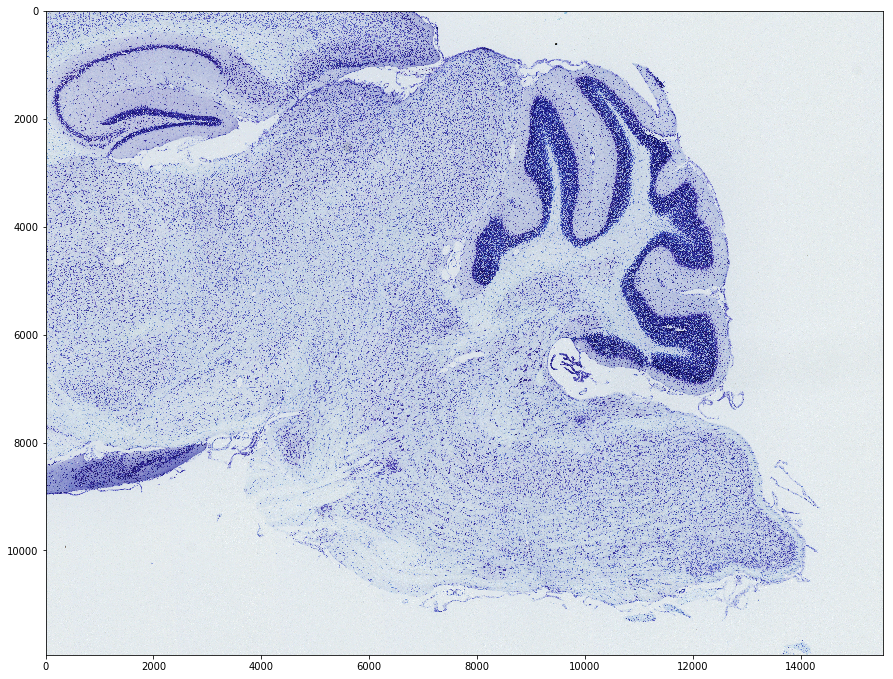

In [25]:
a = imread(img_filename[0])
plt.figure(figsize=(15,15))
plt.imshow(a)

In [5]:
contour_df, _ = DataManager.load_annotation_v3(stack=stack);
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df, stack);
contour_df

'No object named structures in the file'


Annotation has no structures.


creator downsample  \
10001747656938   yuncong          1   
100179733918340  yuncong          1   
100436364177927  yuncong          1   
100739086246252  yuncong          1   
100789576647628  yuncong          1   
100920121924561  yuncong          1   
101502220498012  yuncong          1   
101511503885989  yuncong          1   
101528011891079  yuncong          1   
101709650119044  yuncong          1   
101766370294917  yuncong          1   
101798332186952  yuncong          1   
101835871596726  yuncong          1   
101860661226065  yuncong          1   
102327450093589  yuncong          1   
102364145529843  yuncong          1   
102894477533672  yuncong          1   
10305105721462   yuncong          1   
103068813277037  yuncong          1   
103164799567817  yuncong          1   
103167177058136  yuncong          1   
103185227814691  yuncong          1   
103227188346909  yuncong          1   
103371609852368  yuncong          1   
103441960876852  yuncong          1   
103456702454204  yuncong          1   
103621508216997  yuncong          1   
103706406166204  yuncong          1   
103732852355920  yuncong          1   
104150322368967  yuncong          1   
...                  ...        ...   
97016267603086   yuncong          1   
97170259116334   yuncong          1   
97346173467704   yuncong          1   
97404696017701   yuncong          1   
97504196731817   yuncong          1   
97619991952827   yuncong          1   
97890985022292   yuncong          1   
9791958451837    yuncong          1   
97971861082886   yuncong          1   
98069629546362   yuncong          1   
98214393752096   yuncong          1   
98330724938210   yuncong          1   
98348450774378   yuncong          1   
98371271576446   yuncong          1   
98407500342633   yuncong          1   
98419828539590   yuncong          1   
98698157497252   yuncong          1   
98700835314001   yuncong          1   
98748026747925   yuncong          1   
9886055009911    yuncong          1   
99140085222196   yuncong          1   
99183589352753   yuncong          1   
99199686302154   yuncong          1   
9928915712736    yuncong          1   
99429586937135   yuncong          1   
99579169895708   yuncong          1   
99657345404738   yuncong          1   
9990699061935    yuncong          1   
99910308596392   yuncong          1   
99960330881585   yuncong          1   

                                                             edits flags  \
10001747656938   [{u'username': u'yuncong', u'timestamp': u'091...     1   
100179733918340  [{u'username': u'yuncong', u'timestamp': u'091...     1   
100436364177927  [{u'username': u'yuncong', u'timestamp': u'091...     1   
100739086246252  [{u'username': u'yuncong', u'timestamp': u'091...     0   
100789576647628  [{u'username': u'yuncong', u'timestamp': u'091...     0   
100920121924561  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101502220498012  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101511503885989  [{u'username': u'yuncong', u'timestamp': u'091...     0   
101528011891079  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101709650119044  [{u'username': u'yuncong', u'timestamp': u'091...     0   
101766370294917  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101798332186952  [{u'username': u'yuncong', u'timestamp': u'091...     0   
101835871596726  [{u'username': u'yuncong', u'timestamp': u'091...     1   
101860661226065  [{u'username': u'yuncong', u'timestamp': u'091...     0   
102327450093589  [{u'username': u'yuncong', u'timestamp': u'091...     1   
102364145529843  [{u'username': u'yuncong', u'timestamp': u'091...     1   
102894477533672  [{u'username': u'yuncong', u'timestamp': u'091...     1   
10305105721462   [{u'username': u'yuncong', u'timestamp': u'091...     1   
103068813277037  [{u'username': u'yuncong', u'timestamp': u'091...     1   
103164799567817  [{u'username': u'yuncong', u'timestamp': u'091...     0   
10

### Training perceptron for 7N 

In [10]:
structure_name = '7N'
# Swapping order of vertices coordinate to be consistant with numpy
vertices_dic_7N = {cnt['section'] : np.array(cnt['vertices']) for _, cnt in contour_df[contour_df['name']==structure_name].iterrows()}

In [11]:
sectionList_7N = vertices_dic_7N.keys()
secIndex = 0;
sec = sectionList_7N[secIndex]
margin = 200

In [16]:
im_1_max,im_0_max = np.max(np.array(vertices_dic_7N[sec],dtype=np.int),axis=0)
im_1_min,im_0_min = np.min(np.array(vertices_dic_7N[sec],dtype=np.int),axis=0)

In [17]:
im_0_min,im_1_min,im_0_max,im_1_max

(10181, 7816, 10550, 8578)

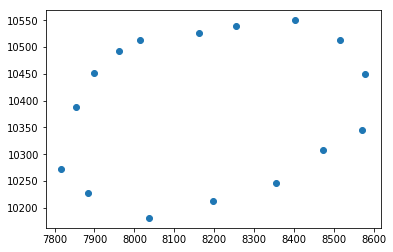

In [14]:
plt.scatter(vertices_dic_7N[sec][:,0],vertices_dic_7N[sec][:,1])

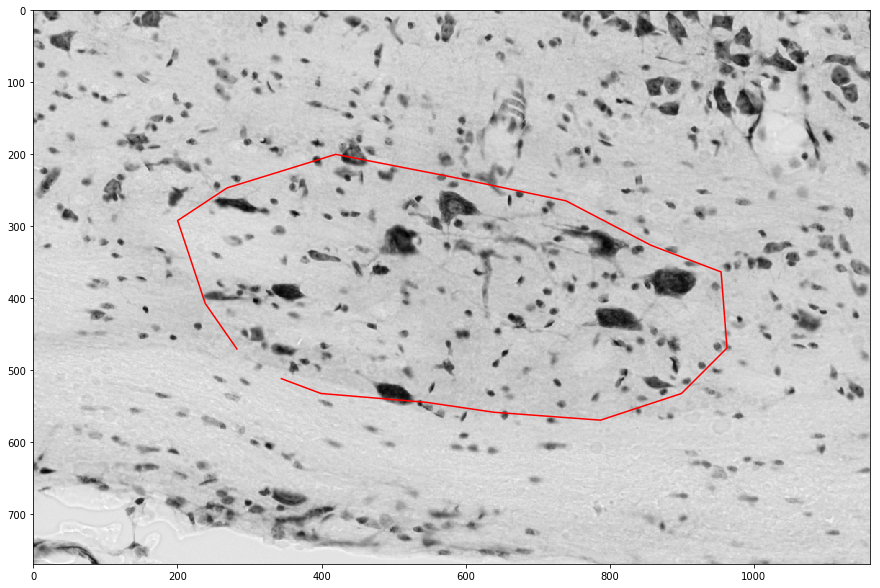

In [28]:
# Visualize the chosen structure:
# The order of vertices is (x,y) -> (dim_1, dim_0) in numpy
plt.figure(figsize=(15,15))
plt.imshow(fun_crop_images(im_rescale[secIndex],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)
plt.plot(vertices_dic_7N[sec][:,0] - im_1_min + margin,vertices_dic_7N[sec][:,1]-im_0_min + margin,'-r')

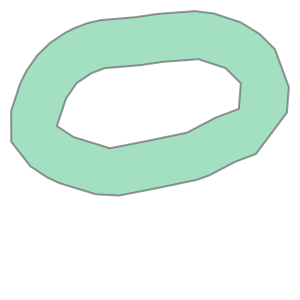

In [29]:
a = Polygon(vertices_dic_7N[sec])
surround = a.buffer(margin,resolution=2)
surround = surround.difference(a)
surround

## Reconstruct labeled image from detected cell dataset, with visualization

In [30]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [31]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = []
im_label = []
im_BW = []
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSecIndex in range(n_images):
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSecIndex],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label.append(temp_im_label)
    im_BW.append(temp_im_label>0)
    im_blob_prop[secIndexList[tempSecIndex]]  = temp_im_blob_prop
    
n_blobs = map(len, im_blob_prop.values())

Blob Index 29659


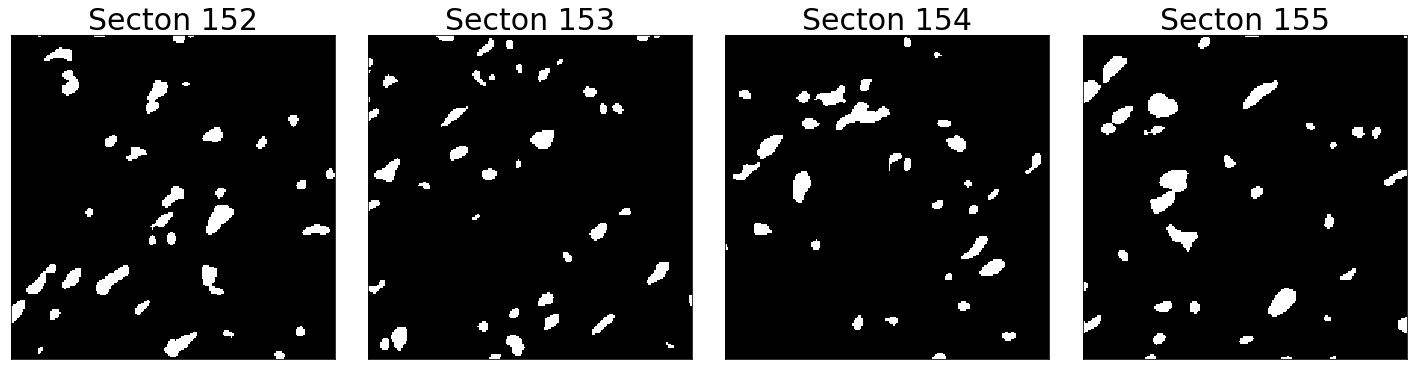

Blob Index 5318


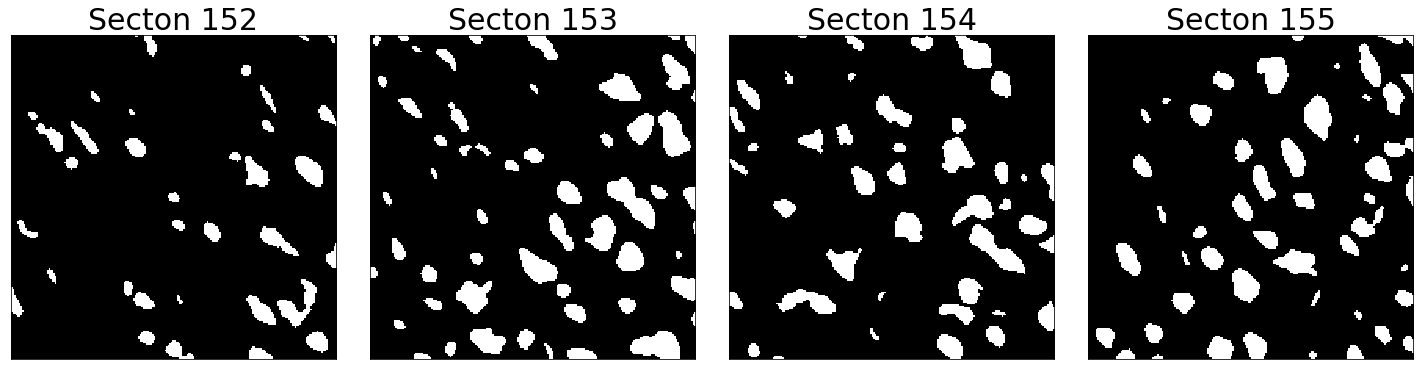

Blob Index 1428


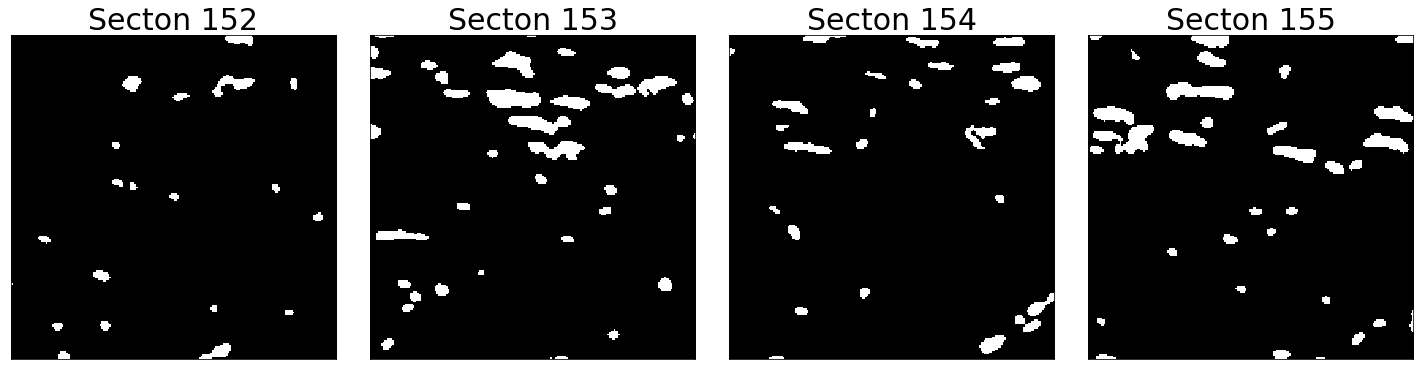

Blob Index 34361


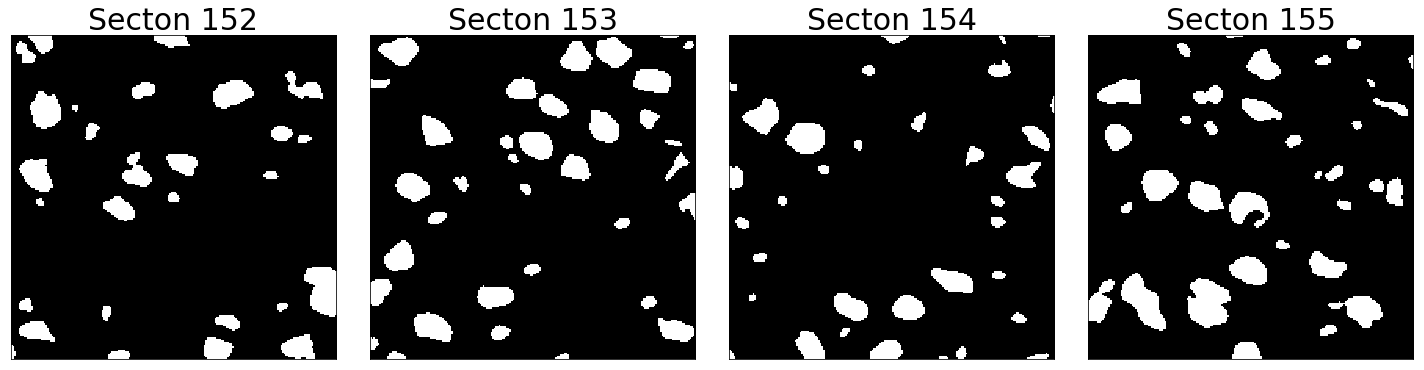

Blob Index 37152


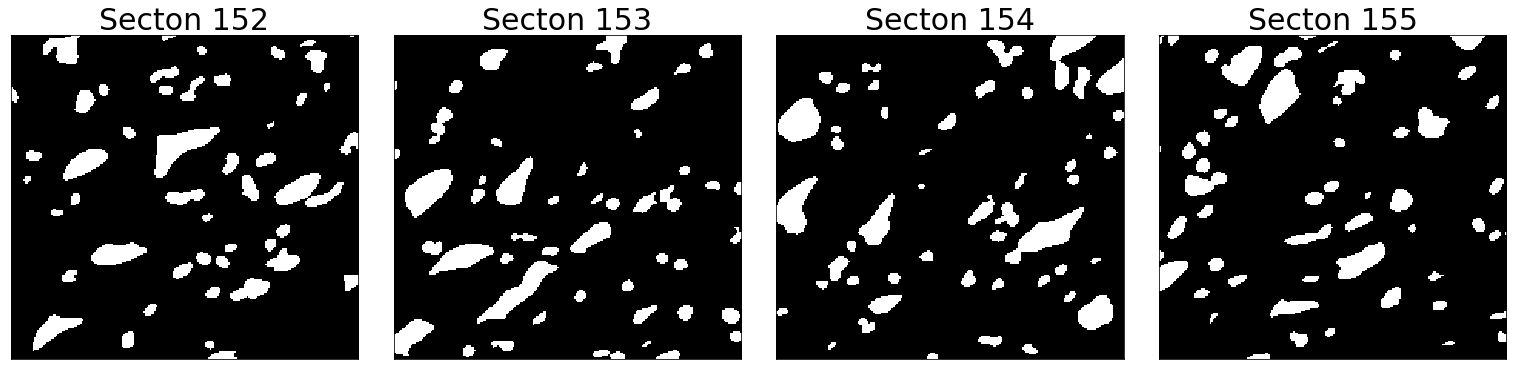

Blob Index 59064


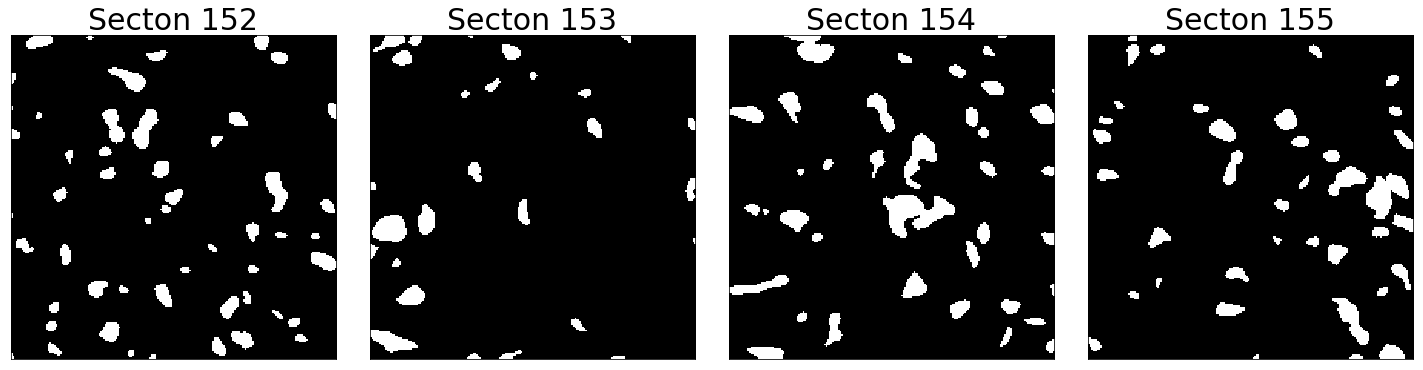

Blob Index 56473


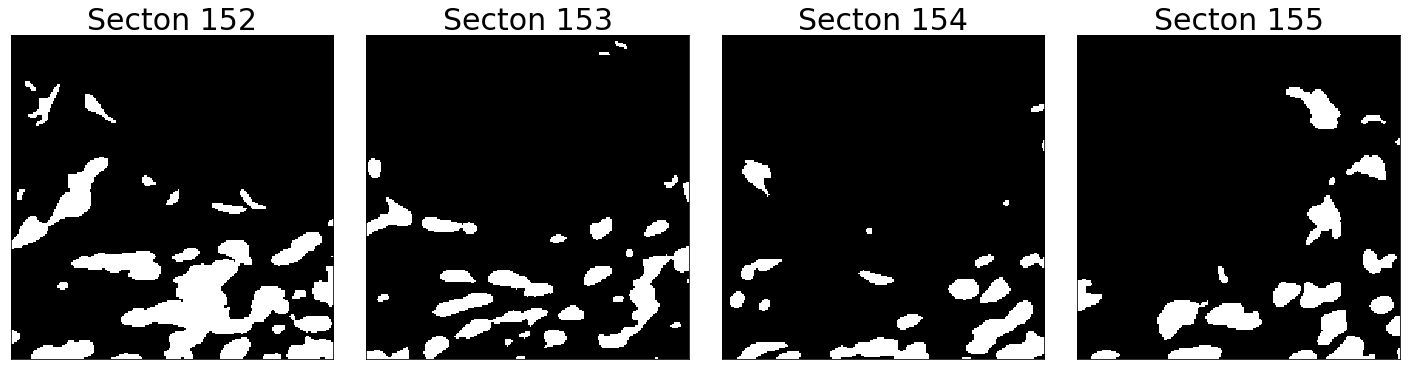

Blob Index 61839


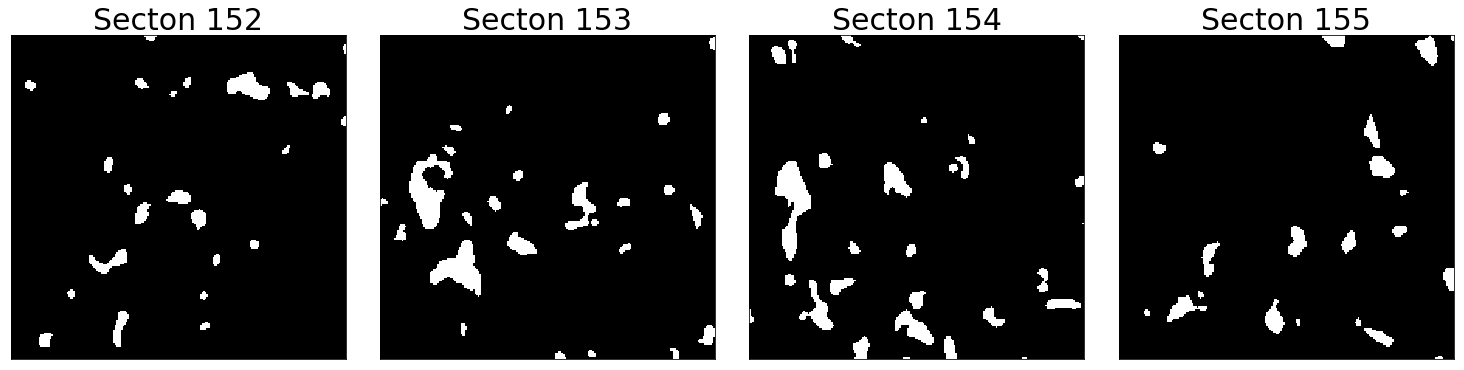

Blob Index 67764


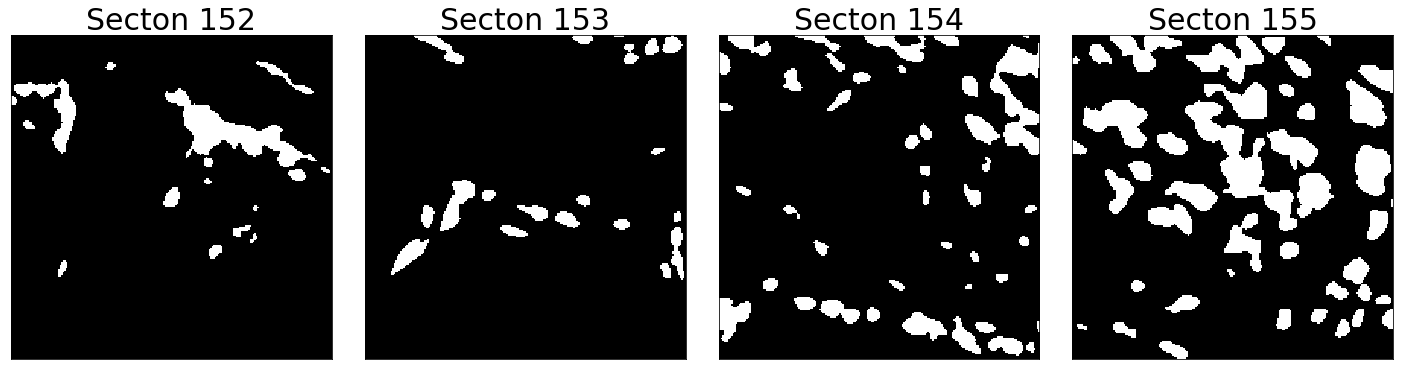

Blob Index 51103


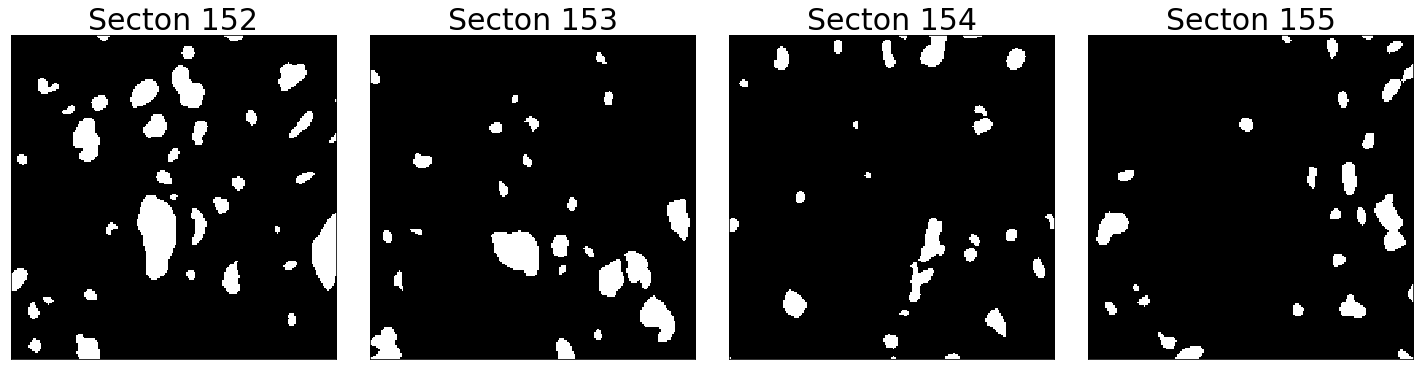

In [47]:
secIndex = 0
option_vis_blob_margin = 100
sec = secIndexList[secIndex]
for tempBlobIndex in np.random.choice(range(0,n_blobs[secIndex]),10):
    print('Blob Index %d' % tempBlobIndex)
#     display_images_in_grids([fun_crop_images(im_rescale[tempSecIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margin) 
#                              for tempSecIndex in range(n_images)],
#                             titles=['Secton %d' % tempSec for tempSec in secIndexList],
#                             nc=5,cmap=plt.cm.gray)
    display_images_in_grids([fun_crop_images(im_BW[tempSecIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margin,im0max=im0max,im1max=im1max) 
                         for tempSecIndex in range(n_images)],
                        titles=['Secton %d' % tempSec for tempSec in secIndexList],
                        nc=4,cmap=plt.cm.gray)

## Get the blobs inside the selected strucutre

### Get blob properties in the next section

In [658]:
secIndex = 0
sec = secIndexList[secIndex]
blobID = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
o_scan_size_coeff = 5

In [52]:
# Get all the blobs inside the selected structure in the current section
temp_curr_sec_blob_centroid = [im_blob_prop[sec][tempBIdx]['centroid'] for tempBIdx in range(n_blobs[secIndex]) ]
tempPath = matplotlib.path.Path(vertices_dic_7N[sec][:,[1,0]])# Swap the order of vertices 
tempBlobInside = tempPath.contains_points(temp_curr_sec_blob_centroid)
tempBlobIndex = np.arange(0,n_blobs[secIndex],dtype=np.int32)
tempBlobInsideIndex = tempBlobIndex[tempBlobInside]
temp_curr_BlobsProps_in_structure = np.array(im_blob_prop[sec])[tempBlobInside]
temp_curr_BlobsNum_in_structure = len(temp_curr_BlobsProps_in_structure)

# Get blobs in the margin of structure of current section
temp_PosSam_Polygon = Polygon(vertices_dic_7N[sec][:,[1,0]])
temp_surround = temp_PosSam_Polygon.buffer(margin,resolution=2)
tempPath_surr = matplotlib.path.Path(list(temp_surround.exterior.coords))
tempBlobInside_surr = tempPath_surr.contains_points(temp_curr_sec_blob_centroid)
tempBlobInside_surr = np.logical_xor(tempBlobInside,tempBlobInside_surr)
tempBlobSurrIndex = tempBlobIndex[tempBlobInside_surr]
temp_curr_BlobsProps_in_structure_surr = np.array(im_blob_prop[sec])[tempBlobInside_surr]
temp_curr_BlobsNum_in_structure_surr = len(temp_curr_BlobsProps_in_structure_surr)

# Assuming that all blobs in the structure are "typical" and all blobs in the marginal area are "Not Typical"

In [66]:
idx1 = 0
idx2 = 1
props_for_comparison = ['area', 'orientation','moments_hu']

## Construct positive training set

In [67]:
temp_sim = {}
temp_pos_sample = []
for idx1 in range(temp_curr_BlobsNum_in_structure):
    temp_curr_blob_props = {}
    for tempProp in props_for_comparison:
        temp_prop_value = []
        for blobIndex in range(temp_curr_BlobsNum_in_structure):
            if blobIndex != idx1:
                temp_prop_value.append(temp_curr_BlobsProps_in_structure[blobIndex][tempProp])
        temp_curr_blob_props[tempProp] = temp_prop_value   
        
    # Generate positive sample. (num_sample, num_features = 11)     
    for prop in props_for_comparison:
        temp_sim[prop] = fun_similarity(temp_curr_BlobsProps_in_structure[idx1][prop], temp_curr_blob_props[prop],distance_type=prop)
    temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in props_for_comparison))
    temp_pos_sample.append(temp_sim_matrix)
temp_pos_sample = np.vstack(tuple(temp_pos_sample))
temp_pos_label = np.array(np.ones([np.size(temp_pos_sample,axis=0)]),dtype=np.bool)

## Construct negative training set

In [68]:
temp_sim = {}
temp_curr_surrblob_props = {}
temp_neg_sample = []
for idx1 in range(temp_curr_BlobsNum_in_structure):
    for tempProp in props_for_comparison:
        temp_prop_value = []
        for blobIndex in range(temp_curr_BlobsNum_in_structure_surr):
            temp_prop_value.append(temp_curr_BlobsProps_in_structure_surr[blobIndex][tempProp])
        temp_curr_surrblob_props[tempProp] = temp_prop_value

    for prop in props_for_comparison:
        temp_sim[prop] = fun_similarity(temp_curr_BlobsProps_in_structure[idx1][prop], temp_curr_surrblob_props[prop],distance_type=prop)
    temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in props_for_comparison))
    temp_neg_sample.append(temp_sim_matrix)
temp_neg_sample = np.vstack(tuple(temp_neg_sample))
temp_neg_label = np.array(np.zeros([np.size(temp_neg_sample,axis=0)]),dtype=np.bool)

In [69]:
training_set = np.vstack((temp_pos_sample,temp_neg_sample))
training_label = np.concatenate((temp_pos_label,temp_neg_label))

# Learning

In [64]:
import sklearn

In [70]:
model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=False,n_iter=10,shuffle=True).fit(training_set,training_label)
training_accuracy = model_perceptron.score(training_set,training_label)
print 'The training accuracy is %f' %training_accuracy
print 'Coefficients are:', model_perceptron.coef_

The training accuracy is 0.621160
Coefficients are: [[-0.30134672 -0.94354544 -0.09081897 -0.11809082 -0.43868268 -1.30707492
  -0.24812673 -0.33873012  0.21702809]]


### Accuracy vs n_iter

In [71]:
import random

In [72]:
n_iteration = range(1,51)
training_accuracy = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=True,n_iter=n_iter,shuffle=True,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))

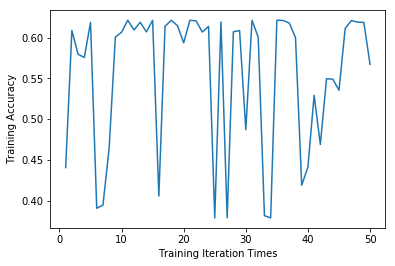

In [73]:
plt.plot(n_iteration,training_accuracy);
plt.xlabel('Training Iteration Times')
plt.ylabel('Training Accuracy')

### Accuracy replicablility

In [74]:
n_iteration = range(1,51)
training_accuracy = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=True,n_iter=10,shuffle=True,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))

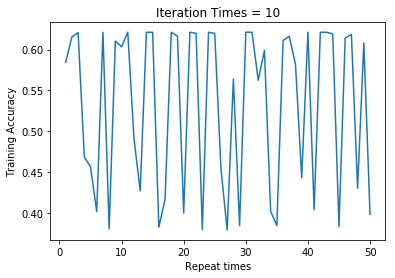

In [75]:
plt.plot(n_iteration,training_accuracy);
plt.xlabel('Repeat times')
plt.ylabel('Training Accuracy')
plt.title('Iteration Times = 10')

### Trun off shuffle

In [76]:
n_iteration = range(1,51)
training_accuracy = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=True,n_iter=10,shuffle=False,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))

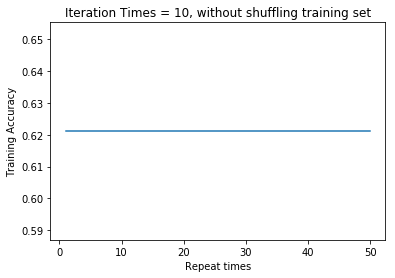

In [77]:
plt.plot(n_iteration,training_accuracy);
plt.xlabel('Repeat times')
plt.ylabel('Training Accuracy')
plt.title('Iteration Times = 10, without shuffling training set')

### Fluctuation of coefficient

In [78]:
n_iteration = range(1,51)
training_accuracy = []
coeff = []
for n_iter in n_iteration:
    model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=True,n_iter=10,shuffle=True,random_state=random.seed()).fit(training_set,training_label)
    training_accuracy.append(model_perceptron.score(training_set,training_label))
    coeff.append(model_perceptron.coef_)

In [141]:
props_for_comparison

['area', 'orientation', 'moments_hu']

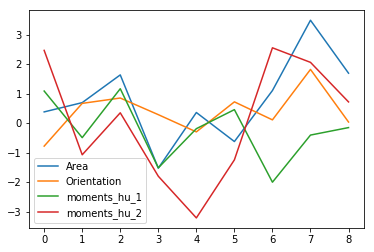

In [142]:
plt.plot(np.vstack(tuple(coeff)).T[:,[0,1,2,3]]);
plt.legend(['Area','Orientation','moments_hu_1','moments_hu_2'])

# Analyzing result

### Confusion matrix

In [123]:
model_perceptron = sklearn.linear_model.perceptron.Perceptron(fit_intercept=True,n_iter=20,shuffle=True,random_state=random.seed()).fit(training_set,training_label)

In [124]:
predt = model_perceptron.predict(training_set)         

true_positive_idx = np.logical_and(training_label==True, predt == True)
true_positive_idx = np.where(true_positive_idx==True)[0]
true_positive_num = len(true_positive_idx)

true_negative_idx = np.logical_and(training_label==False, predt == False)
true_negative_idx = np.where(true_negative_idx==True)[0]
true_negative_num = len(true_negative_idx)

false_positive_idx = np.logical_and(training_label==False, predt == True)
false_positive_idx = np.where(false_positive_idx==True)[0]
false_positive_num = len(false_positive_idx)

false_negative_idx = np.logical_and(training_label==True, predt==False)
false_negative_idx = np.where(false_negative_idx==True)[0]
false_negative_num = len(false_negative_idx)

predt_true_num = true_positive_num + false_positive_num
predt_false_num = true_negative_num + false_negative_num

In [125]:
confusion_matrix = np.array([[true_positive_num,false_positive_num],
          [false_negative_num,true_negative_num]],dtype=np.float)/np.array([[predt_true_num,predt_true_num],[predt_false_num,predt_false_num]])

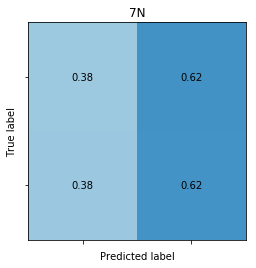

In [126]:
plot_confusion_matrix(confusion_matrix,labels=['',''],title=structure_name);

### Visualize true - positive pairs

In [150]:
idx0 = 0
temp_convert_list_to_matrix_idx = {}
for idx1 in range(temp_curr_BlobsNum_in_structure):
    for idx2 in range(temp_curr_BlobsNum_in_structure):
        if idx1 != idx2:
            temp_convert_list_to_matrix_idx[idx0]=frozenset([idx1,idx2])
            idx0 +=1

In [151]:
true_pos_matched_pair = [temp_convert_list_to_matrix_idx[idx] for idx in true_positive_idx]
true_pos_matched_pair_duplicated = true_pos_matched_pair
true_pos_matched_pair = map(list,set(true_pos_matched_pair))
true_pos_matched_pair.sort()

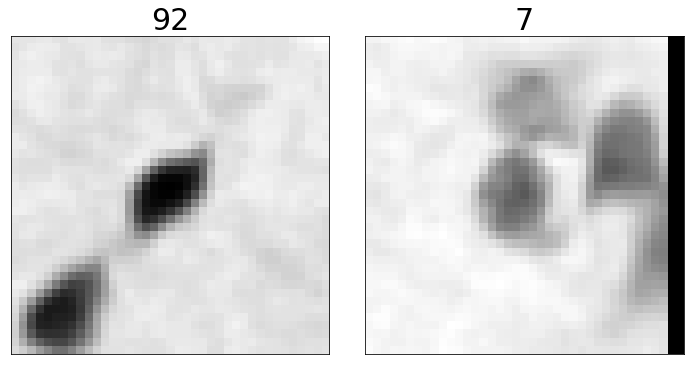

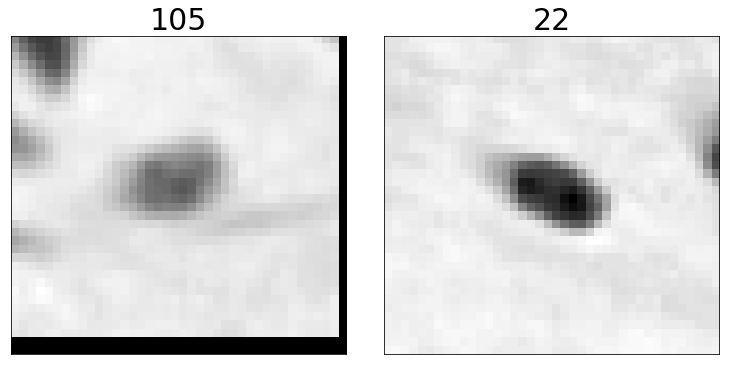

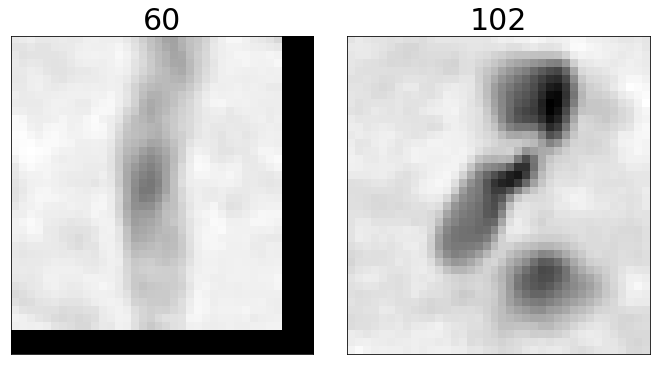

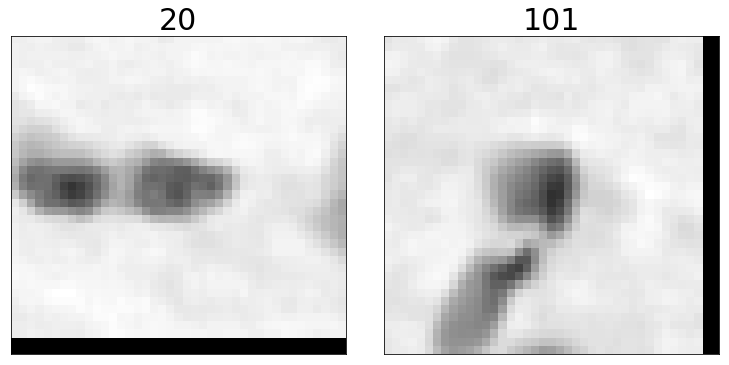

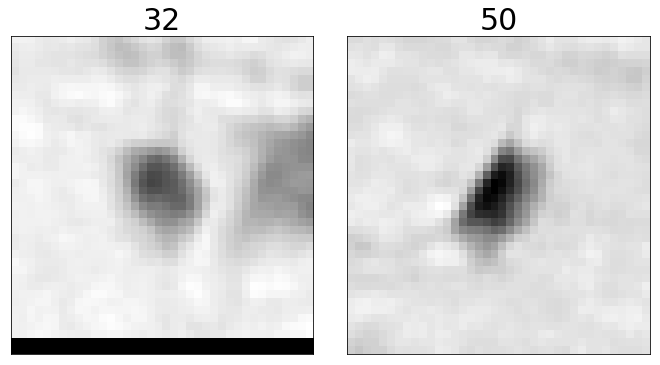

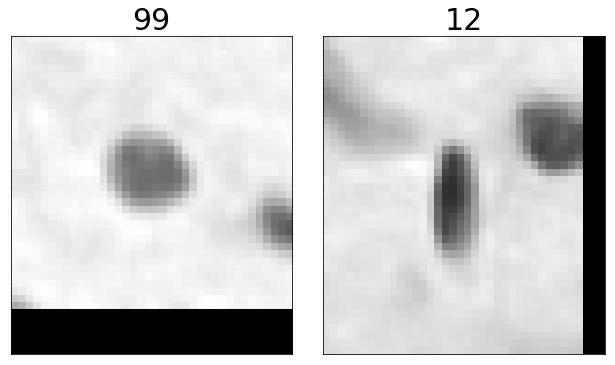

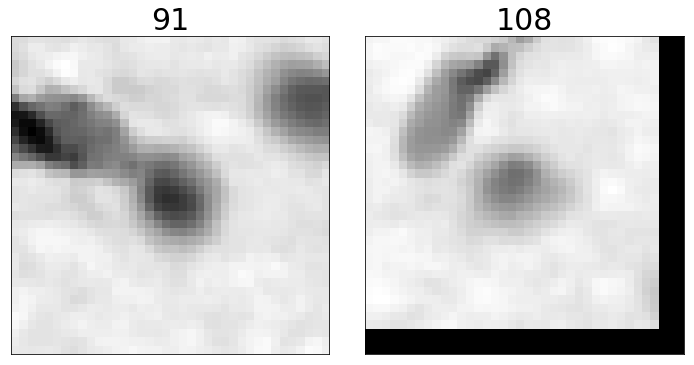

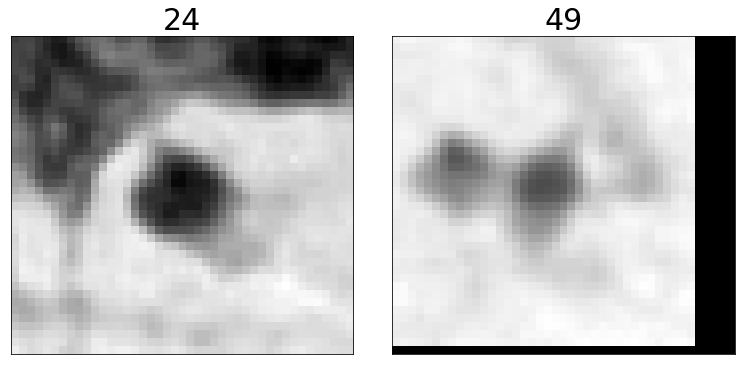

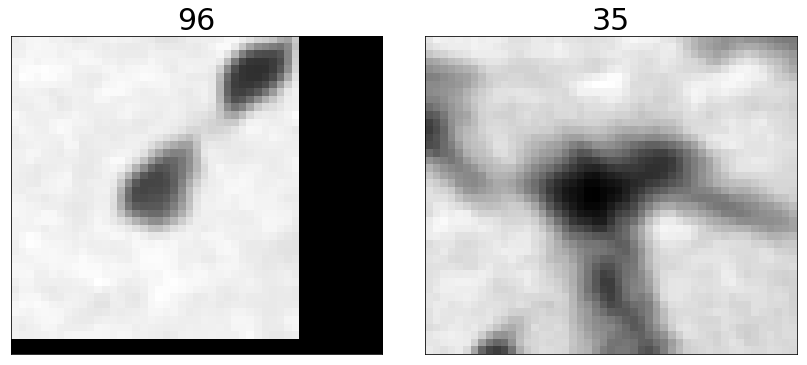

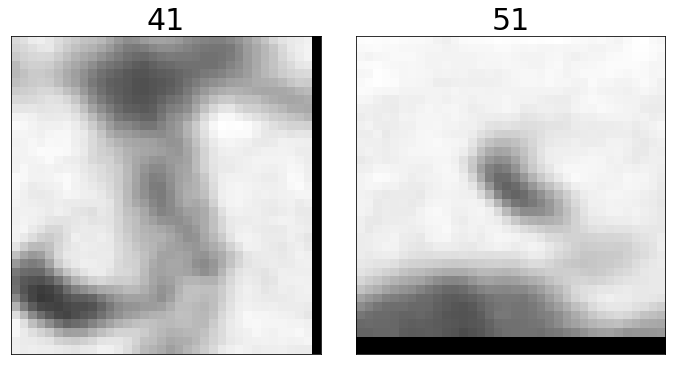

In [129]:
margin = 15
for idx1,idx2 in random.sample(true_pos_matched_pair,10):
    display_images_in_grids([fun_crop_images(im_rescale[secIndex],*temp_curr_BlobsProps_in_structure[idx1]['bbox'],im0max=im0max,im1max=im1max,margin=margin),
    fun_crop_images(im_rescale[secIndex],*temp_curr_BlobsProps_in_structure[idx2]['bbox'],im0max=im0max,im1max=im1max,margin=margin)
    ],nc=2,cmap=plt.cm.gray,titles=[idx1,idx2]                            
    )

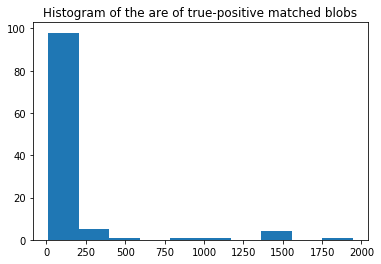

In [130]:
# Histogram of true-positive pair

plt.hist([temp_curr_BlobsProps_in_structure[idx]['area'] for idx in np.array(list(set(np.array(true_pos_matched_pair).flatten())),dtype=np.int16)]);
plt.title('Histogram of the are of true-positive matched blobs')

### Visualize False-positive

In [131]:
idx0_surr = len(temp_pos_label)
temp_convert_list_to_matrix_idx_surr = {}
for idx1 in range(temp_curr_BlobsNum_in_structure):
    for idx2 in range(temp_curr_BlobsNum_in_structure_surr):
        temp_convert_list_to_matrix_idx_surr[idx0_surr]=[idx1,idx2]
        idx0_surr +=1

In [132]:
false_pos_matched_pair = [temp_convert_list_to_matrix_idx_surr[idx] for idx in false_positive_idx]

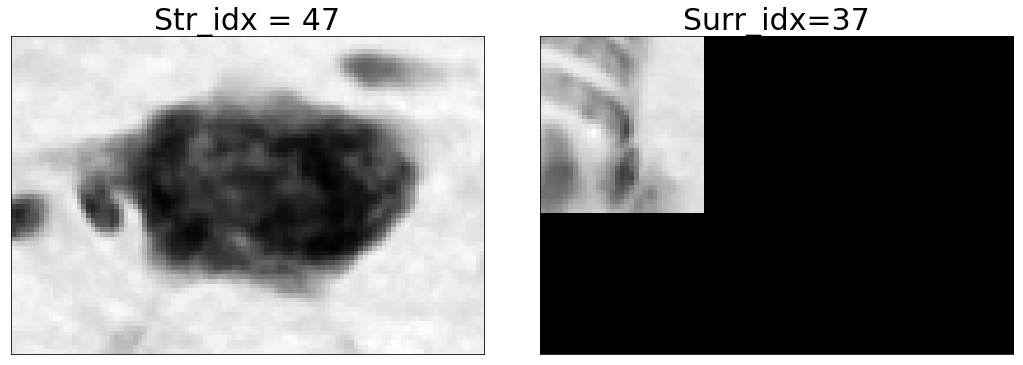

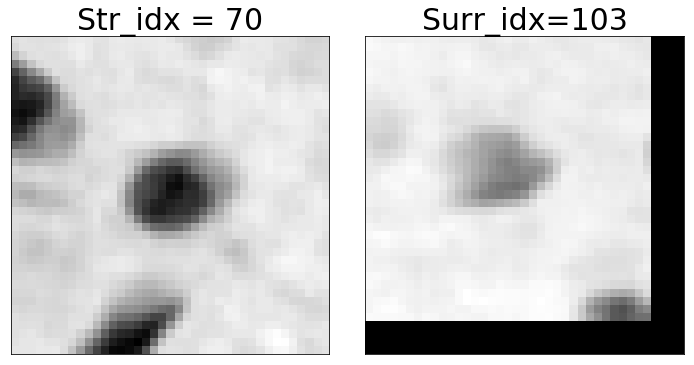

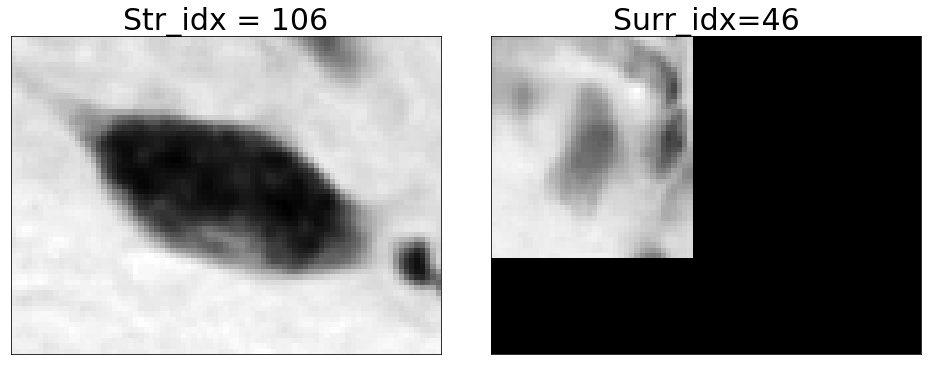

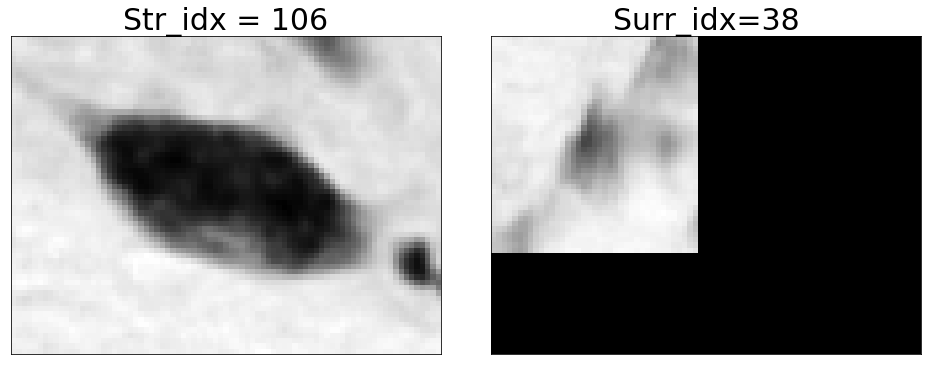

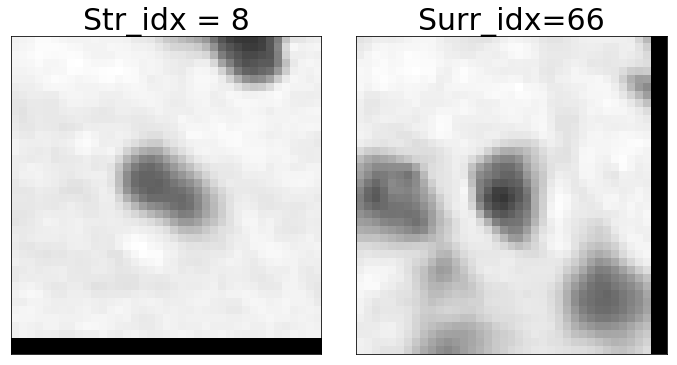

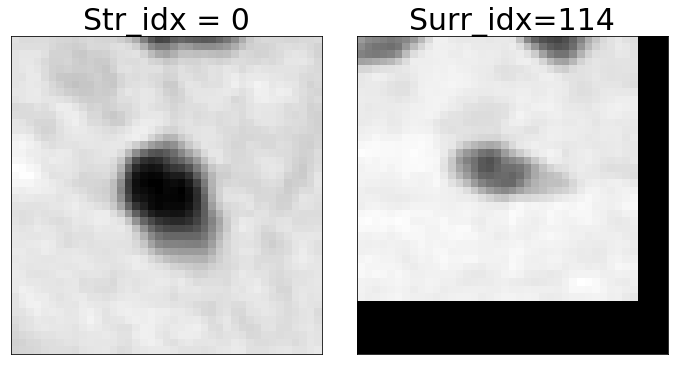

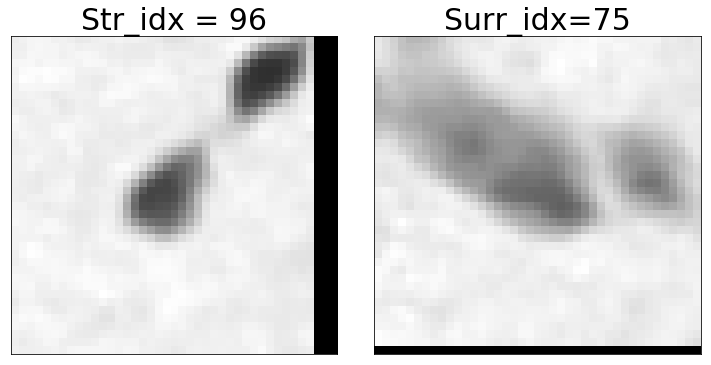

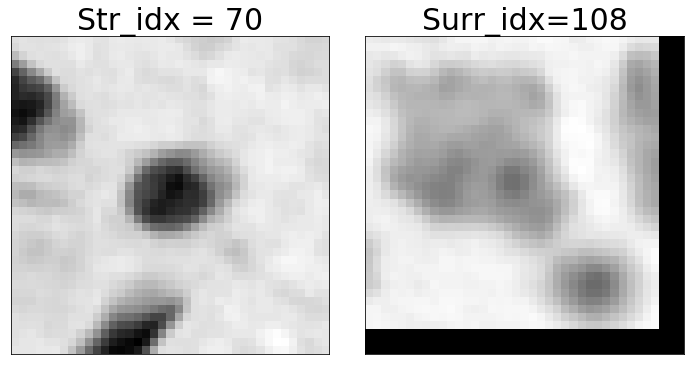

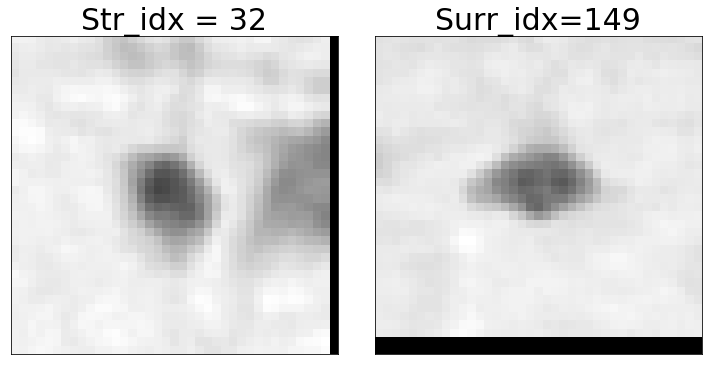

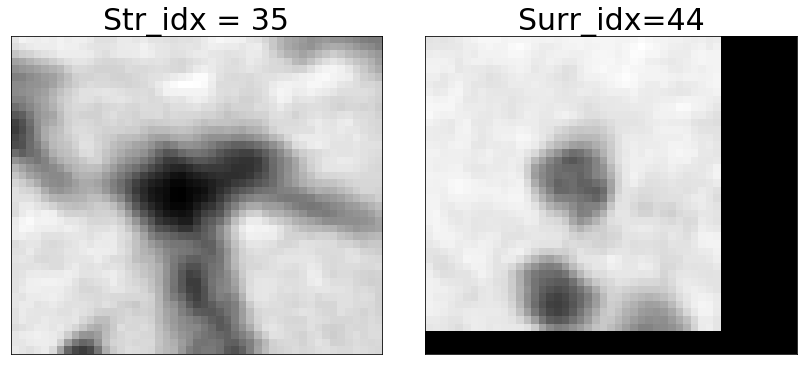

In [133]:
margin = 15
for idx1,idx2 in random.sample(false_pos_matched_pair,10):
    display_images_in_grids([fun_crop_images(im_rescale[secIndex],*temp_curr_BlobsProps_in_structure[idx1]['bbox'],im0max=im0max,im1max=im1max,margin=margin),
    fun_crop_images(im_rescale[secIndex],*temp_curr_BlobsProps_in_structure_surr[idx2]['bbox'],im0max=im0max,im1max=im1max,margin=margin)
    ],nc=2,cmap=plt.cm.gray,titles=['Str_idx = %d'%idx1,'Surr_idx=%d'%idx2]                            
    )

# Check typical cells

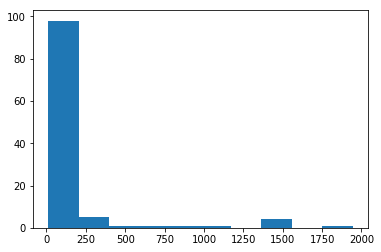

In [135]:
# Find the large cell in the structure:
temp_curr_BlobsArea_in_structure = [temp_curr_BlobsProps_in_structure[idx]['area'] for idx in range(temp_curr_BlobsNum_in_structure)]
plt.hist(temp_curr_BlobsArea_in_structure);

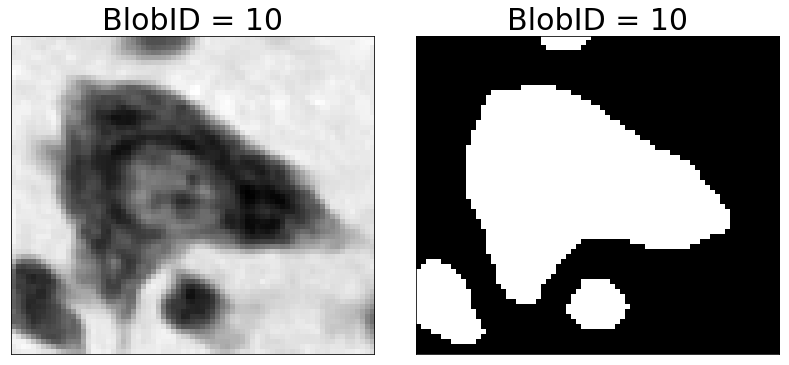

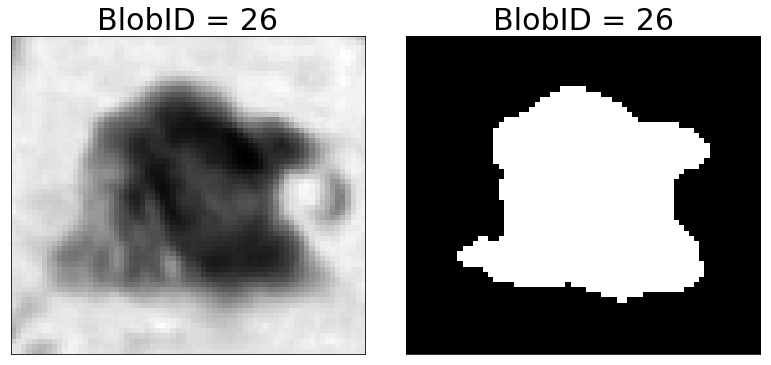

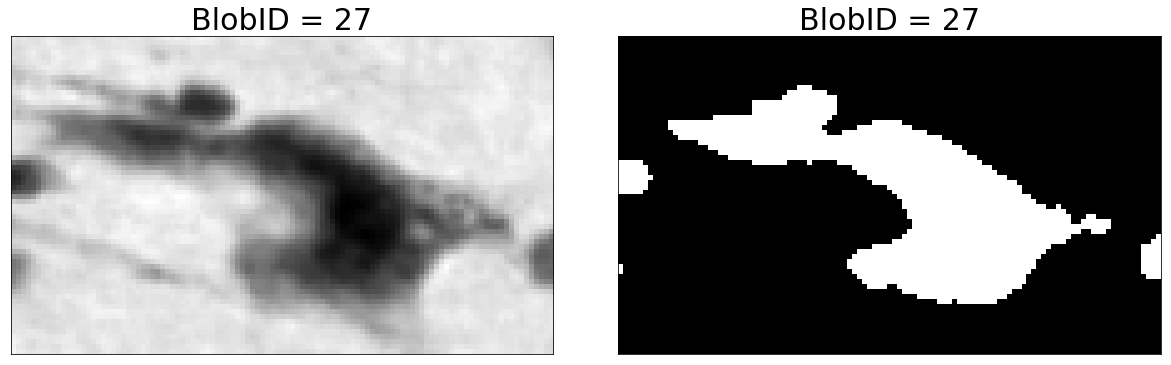

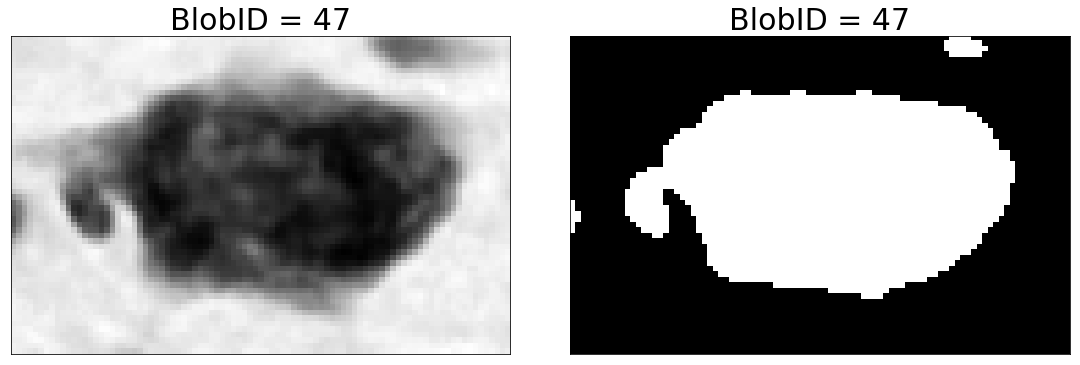

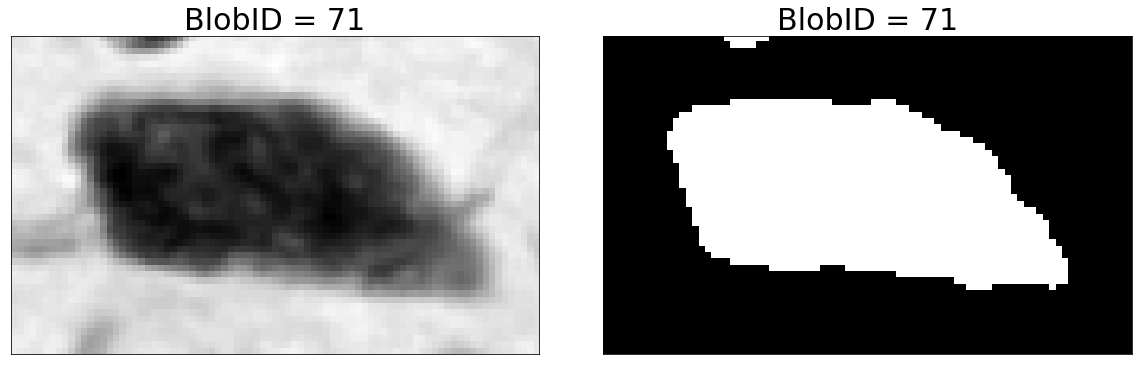

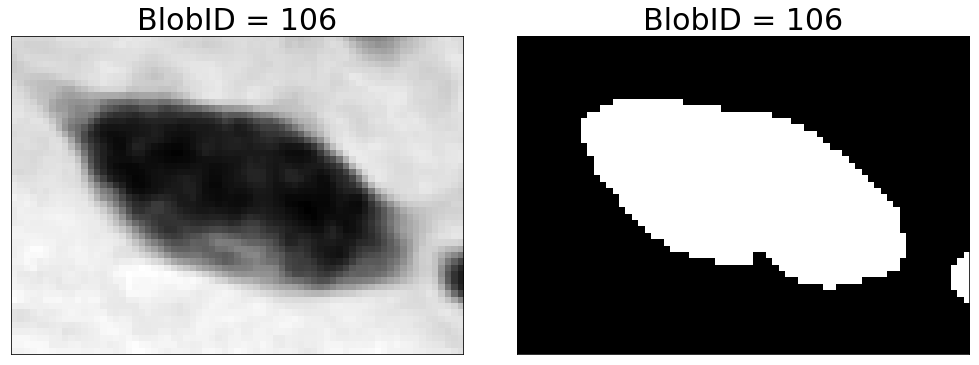

In [149]:
for idx in np.where(np.array(temp_curr_BlobsArea_in_structure)>800)[0]:
    display_images_in_grids([fun_crop_images(im_rescale[secIndex],*temp_curr_BlobsProps_in_structure[idx]['bbox'],im0max=im0max,im1max=im1max,margin=10),
                            fun_crop_images(im_BW[secIndex],*temp_curr_BlobsProps_in_structure[idx]['bbox'],im0max=im0max,im1max=im1max,margin=10)],
                            titles=['BlobID = %d'%idx, 'BlobID = %d'%idx],nc=2,cmap=plt.cm.gray)

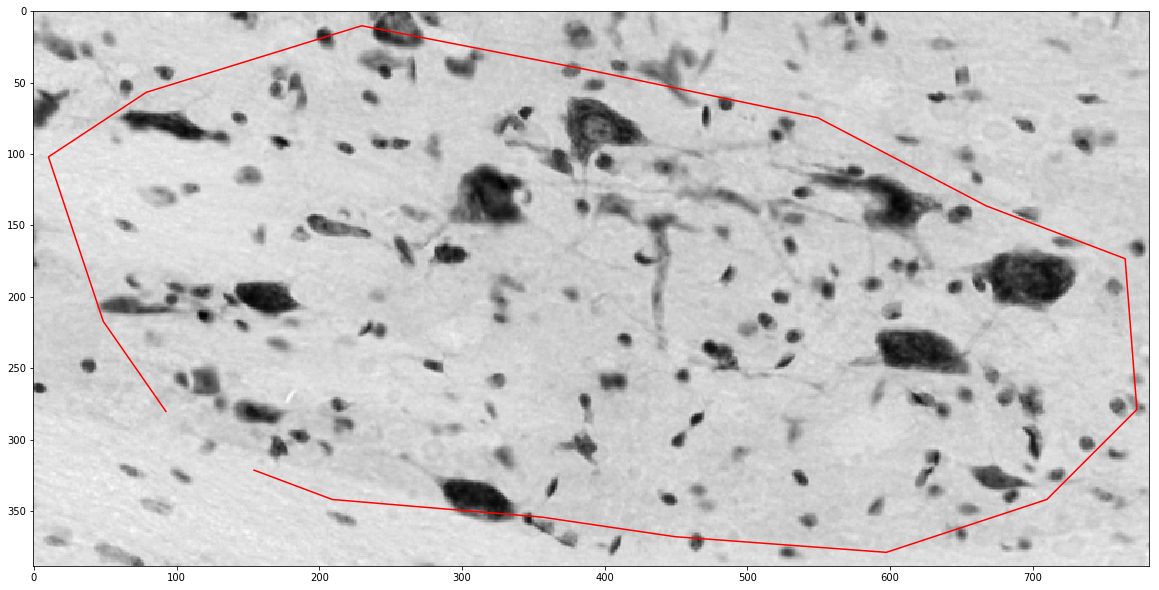

In [137]:
# Visualize the chosen structure:
margin=10
plt.figure(figsize=(20,20))
plt.imshow(fun_crop_images(im_rescale[secIndex],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)
plt.plot(vertices_dic_7N[sec][:,0]-im_1_min+margin,vertices_dic_7N[sec][:,1] - im_0_min + margin,'-r')

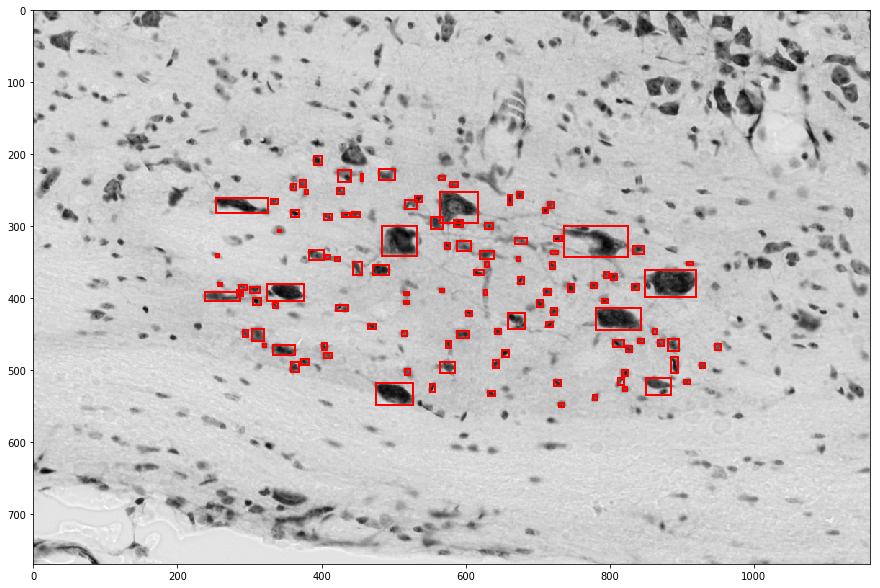

In [146]:
margin = 200
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(fun_crop_images(im_rescale[secIndex],im_0_min,im_1_min,im_0_max,im_1_max,im0max=im0max,im1max=im1max,margin=margin),cmap=plt.cm.gray)
for prop in temp_curr_BlobsProps_in_structure:
    min0, min1, max0, max1 = prop['bbox'];
    rect = matplotlib.patches.Rectangle((min1-im_1_min + margin,min0-im_0_min + margin),max1-min1, max0-min0, fill=False,edgecolor='red',linewidth=2)
    ax.add_patch(rect)
plt.show()

## Manually examine large cells:
Large blob index: 10, 26, 27, 47, 71, 106
predicted similar pair:
- 10 with 26, 27, 47, 106
- 26 with 27, 71
- 27 with 71
- 47 with 71
- 71 with 106